In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Understanding dataset
#### According to the documentation:
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.
#### Source: https://data.mendeley.com/datasets/rscbjbr9sj/2

### Importing Modules
In this step we are importing necessary modules we need in order to pre-process out data and build model on top it. Some of the most important modules we will be using is Python's pandas, matplotlib, sklearn, keras and tensorflow. 

In [0]:
# Importing modules
import os
import cv2
import glob
import h5py
import shutil

# Modules for image preprocessing and visualization
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from skimage.io import imread
from skimage.transform import resize

# Modules for model evaluation
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Modules for model building and optimization
from keras.models import Sequential, Model, load_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.layers import Input, Flatten, SeparableConv2D, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf

# Output formatting
color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

Using TensorFlow backend.


### Data Preprocessing
In this step we will pre-process our data in order to build model. First to speed up our process we will apply random seed in tensorflow graph level.

In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [0]:
# train dir
data_dir = Path('/content/drive/My Drive/Colab Notebooks/MIP/data/chest_xray')
train_dir = data_dir / 'train'

# validation data directory
val_dir = data_dir / 'val'

# test data directory
test_dir = data_dir / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_df.append((str(img),0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_df.append((str(img), 1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_df.head()

,image,label
0,/content/drive/My Drive/Colab Notebooks/MIP/da...,0
1,/content/drive/My Drive/Colab Notebooks/MIP/da...,1
2,/content/drive/My Drive/Colab Notebooks/MIP/da...,1
3,/content/drive/My Drive/Colab Notebooks/MIP/da...,1
4,/content/drive/My Drive/Colab Notebooks/MIP/da...,1


1    3825
0    1333
Name: label, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


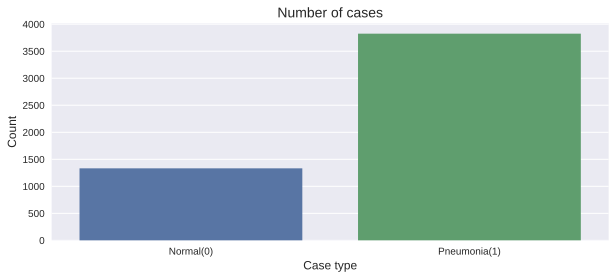

In [0]:
# Get the counts for each class
cases_count = train_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

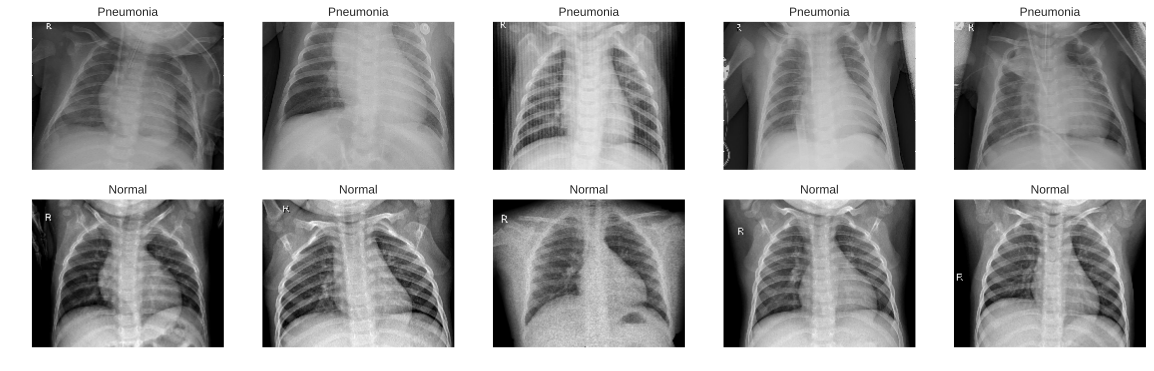

In [0]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(20,6))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=30)]) # roatation

In [0]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3
# batch size for training  
batch_size=16

In [0]:
def data_generator(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size,), dtype=np.float32)
    
    while True:
        # shuffle indices for the training data
        np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = seq.augment_image(img)
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                label = data.iloc[idx]["label"]
                
                batch_data[j] = img
                batch_labels[j] = label
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [0]:
# training data generator 
train_data_gen = data_generator(train_df, batch_size)

In [0]:
def read_images(images, label):
    """
    This function read images from a list of the given
    images. For each image it records a corresponding label.
    
    Args:
        images: list of all images
        label(int): label for these images
    
    Returns:
        data: numpy array containing pre-processed images. The pre-processing
              function is provided by keras
        labels: numpy array of corresponding labels
    """
    data = []
    for img in images:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
        data.append(img)
    
    labels = [label]*len(data)
    data = np.array(data).astype(np.float32)
    data = preprocess_input(data)
    return data, labels

In [0]:
def prepare_data(data_dir):
    """
    This function can be used to prepare the 
    validation and test datasets. 
    
    Args:
        data_dir: A pathlib object pointing to validation/test directory
    
    Returns:
        data: numpy array of all images
        labels: numpy array of corresponding labels
    """
    normal_cases_dir = data_dir / 'NORMAL'
    pneumonia_cases_dir = data_dir / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = list(normal_cases_dir.glob('*.jpeg'))
    pneumonia_cases = list(pneumonia_cases_dir.glob('*.jpeg'))
    print(f"Found {len(normal_cases)} normal cases and {len(pneumonia_cases)} pneumonia_cases")
    
    # process class-wise
    normal_cases_data, normal_cases_labels = read_images(normal_cases, 0)
    pneumonia_cases_data, pneumonia_cases_labels = read_images(pneumonia_cases, 1)
    
    # sanity-check
    assert len(normal_cases_data) == len(normal_cases_labels), "You had one job!"
    assert len(pneumonia_cases_data) == len(pneumonia_cases_labels), "You can't get it right, can you?"
    
    data = np.vstack((normal_cases_data, pneumonia_cases_data))
    labels = np.array((normal_cases_labels + pneumonia_cases_labels)).astype(np.float32)
    
    return data, labels

In [0]:
# Prepare validation data 
validation_data, validation_labels = prepare_data(val_dir)
print(f"Number of validation images: {len(validation_data)} and labels: {len(validation_labels)}")
print(validation_data.shape, validation_labels.shape)

Found 100 normal cases and 100 pneumonia_cases
Number of validation images: 200 and labels: 200
(200, 224, 224, 3) (200,)


In [0]:
# Prepare test data
test_data, test_labels = prepare_data(test_dir)
print("Number of samples in test data: ", len(test_data))
print(test_data.shape, test_labels.shape)

Found 150 normal cases and 348 pneumonia_cases
Number of samples in test data:  498
(498, 224, 224, 3) (498,)


## Training Model
To build our model we will be using convolutional neural network. To get the best accuracy from our model, we will use transfer learning. We will be using early stopping mechanism which will assist us to keep the best model and prevent the model from being overfitting. 

In [0]:
# Get fine-tuning/transfer-learning model
def get_fine_tuning_model(base_model, top_model, inputs, learning_type):
    if learning_type=='transfer_learning':
        print("Doing transfer learning")
        K.set_learning_phase(0)
        base_model.trainable = False
        features = base_model(inputs)
        outputs = top_model(features)
    else:
        print("Doing fine-tuning")
        base_model.trainable = True
        features = base_model(inputs)
        outputs = top_model(features)
    return Model(inputs, outputs)

In [0]:
# Get the base model
base_model = ResNet50(input_shape=(img_rows, img_cols, img_channels), 
                       weights='imagenet', 
                       include_top=False, 
                       pooling='avg')

In [0]:
# Define a top model: extra layers that we are going to add on top of our base network
feature_inputs = Input(shape=base_model.output_shape, name='top_model_input')
x = Dense(50, activation='relu', name='fc1')(feature_inputs)
x = Dropout(0.5,name='drop')(x)
outputs = Dense(1, activation='sigmoid', name='fc2')(x)
top_model = Model(feature_inputs, outputs, name='top_model')

In [0]:
# get model for tranfser learning
inputs = Input(shape=(img_rows, img_cols, img_channels))
model = get_fine_tuning_model(base_model, top_model, inputs, "transfer_learning")
model.summary()

Doing transfer learning
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
top_model (Model)            multiple                  102501    
Total params: 23,690,213
Trainable params: 102,501
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [0]:
# compile the model and check it 
optimizer = RMSprop(0.0001)
model.compile(loss=focal_loss(), optimizer=optimizer, metrics=['accuracy'])

In [0]:
# always use earlystopping
# the restore_best_weights parameter load the weights of the best iteration once the training finishes
es = EarlyStopping(patience=7, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))

# number of epochs 
nb_epochs=10

In [0]:
# train the model 
# fit the model
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=(validation_data, validation_labels),
                              callbacks=[es,chkpt],
                              class_weight={0:1.0, 1:0.33})

model.save('/content/drive/My Drive/Colab Notebooks/MIP/data/medical10.hdf5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
323/323 [==============================] - 2560s 8s/step - loss: 0.0126 - acc: 0.8549 - val_loss: 0.0385 - val_acc: 0.8550
Epoch 2/10
323/323 [==============================] - 176s 545ms/step - loss: 0.0070 - acc: 0.9253 - val_loss: 0.0463 - val_acc: 0.8500
Epoch 3/10
323/323 [==============================] - 180s 558ms/step - loss: 0.0058 - acc: 0.9390 - val_loss: 0.0503 - val_acc: 0.8750
Epoch 4/10
323/323 [==============================] - 179s 553ms/step - loss: 0.0048 - acc: 0.9541 - val_loss: 0.0408 - val_acc: 0.9000
Epoch 5/10
323/323 [==============================] - 178s 551ms/step - loss: 0.0045 - acc: 0.9586 - val_loss: 0.0414 - val_acc: 0.8700
Epoch 6/10
323/323 [==============================] - 179s 554ms/step - loss: 0.0040 - acc: 0.9596 - val_loss: 0.0548 - val_acc: 0.8950
Epoch 7/10
323/323 [==============================] - 180s 557ms/step - loss: 0.0040 - acc: 0.9621 - val_loss: 0.0386 - val_acc: 0.8950
Ep

## Evaluating Model
From the graph it's clear that the accuracy of our model is increasing per  epoch. But after epochs 7 validation loss increased. That means the model started to the overfitting. As we used early stopping mechanism it stop the model from being trained furthermore and keep the model learned model so far. 

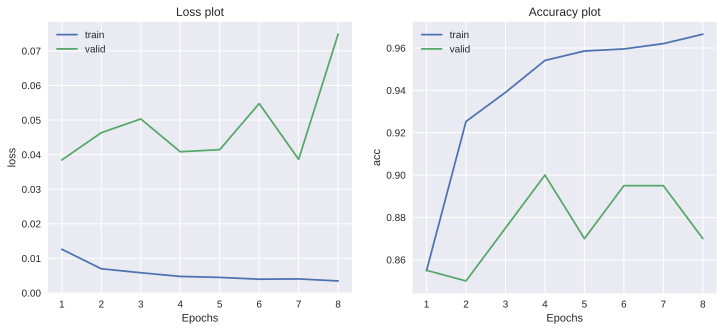

In [0]:
# plot the model loss and accuracy
train_loss = history1.history['loss']
train_acc = history1.history['acc']

valid_loss = history1.history['val_loss']
valid_acc = history1.history['val_acc']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [0]:
# evaluate on test set
test_loss, test_acc = model.evaluate(test_data, test_labels, batch_size=batch_size)
print("Test loss: ", test_loss)
print(f"Test set accuracy: {test_acc*100:.2f}%")

498/498 [==============================] - 4s 8ms/step
Test loss:  0.036096608613610234
Test set accuracy: 86.55%


In [0]:
# Get the predictions on test set
preds = model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')

<Figure size 432x288 with 0 Axes>

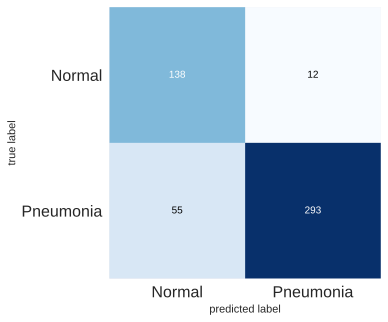

In [0]:
# Get the confusion matrix
cm  = confusion_matrix(orig, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.84
Precision of the model is 0.96


## Conclusion
From the confusion matrix it's clear that the precision of our model is 96% which is quite good and so far the best result for X-ray image. If someone with no phneumonia our model will be able to identify it  with 96% confidence.

## References
- Transfer Learning
- TensorFlow Batch Processing
- ResNet
- Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia